# Task 1: data preparation and customer analytics

## Objective

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy.stats import t as t_dist

Step 1: Exploratory Data Analysis

In [50]:
df = pd.read_csv("./Quantium/QVI_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              246740 non-null  object 
 1   STORE_NBR         246740 non-null  int64  
 2   LYLTY_CARD_NBR    246740 non-null  int64  
 3   TXN_ID            246740 non-null  int64  
 4   PROD_NBR          246740 non-null  int64  
 5   PROD_NAME         246740 non-null  object 
 6   PROD_QTY          246740 non-null  int64  
 7   TOT_SALES         246740 non-null  float64
 8   PACK_SIZE         246740 non-null  int64  
 9   BRAND_NAME        246740 non-null  object 
 10  LIFESTAGE         246740 non-null  object 
 11  PREMIUM_CUSTOMER  246740 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 22.6+ MB


In [51]:
df["STORE_NBR"].nunique()

271

In [52]:
df["DATE"] = pd.to_datetime(df["DATE"])

df["YEARMONTH"] = df["DATE"].dt.year * 100 + df["DATE"].dt.month
df["YEARMONTH"] .head()

0    201810
1    201905
2    201905
3    201808
4    201808
Name: YEARMONTH, dtype: int32

In [53]:
# Define the measure calculations

measureOverTime = (df.groupby(['STORE_NBR', 'YEARMONTH'])
                   .agg(totSales=("TOT_SALES", "sum"),
                        nCustomers=("LYLTY_CARD_NBR", pd.Series.nunique),
                        nTxn=("TXN_ID", pd.Series.nunique),
                        totQty=("PROD_QTY", "sum")
                        )
                   .assign(nTxnPerCust=lambda df: (df["nTxn"] / df["nCustomers"]),
                           nChipsPerTxn=lambda df: (df["totQty"] / df["nTxn"]),
                           avgPricePerUnit =lambda df: (df["totSales"] / df["totQty"]))
                   ).reset_index()

measureOverTime

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxn,totQty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.9,47,49,58,1.042553,1.183673,3.256897
1,1,201808,168.4,41,41,52,1.000000,1.268293,3.238462
2,1,201809,268.1,57,59,71,1.035088,1.203390,3.776056
3,1,201810,175.4,39,40,51,1.025641,1.275000,3.439216
4,1,201811,184.8,44,45,55,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...,...,...
3160,272,201902,385.3,44,47,89,1.068182,1.893617,4.329213
3161,272,201903,421.9,48,51,97,1.062500,1.901961,4.349485
3162,272,201904,445.1,54,55,105,1.018519,1.909091,4.239048
3163,272,201905,314.6,34,40,71,1.176471,1.775000,4.430986


In [54]:
# Filter to the pre-trial period and stores with full observation periods

# Get store numbers with exactly 12 observations
store_counts = measureOverTime.groupby('STORE_NBR').size()
storesWithFullObs = store_counts[store_counts == 12].index

# Filter to only those stores and months before Feb 2019
preTrialMeasures = measureOverTime[
    (measureOverTime['STORE_NBR'].isin(storesWithFullObs)) &
    (measureOverTime['YEARMONTH'] < 201902)
]
preTrialMeasures

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxn,totQty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.9,47,49,58,1.042553,1.183673,3.256897
1,1,201808,168.4,41,41,52,1.000000,1.268293,3.238462
2,1,201809,268.1,57,59,71,1.035088,1.203390,3.776056
3,1,201810,175.4,39,40,51,1.025641,1.275000,3.439216
4,1,201811,184.8,44,45,55,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...,...,...
3155,272,201809,294.5,31,35,69,1.129032,1.971429,4.268116
3156,272,201810,405.1,41,47,94,1.146341,2.000000,4.309574
3157,272,201811,355.8,39,43,83,1.102564,1.930233,4.286747
3158,272,201812,363.1,43,43,81,1.000000,1.883721,4.482716


In [55]:
import pandas as pd

def calculate_correlation(input_table, metric_col, store_comparison):
    """
    Calculates the Pearson correlation coefficient between the metric for a comparison store
    and all other stores across months in the input table.

    Args:
        input_table (pd.DataFrame): The dataset containing store-level metrics.
        metric_col (str): The name of the column to calculate correlation on.
        store_comparison (int): The reference store number to compare against.

    Returns:
        pd.DataFrame: A table with correlations between the comparison store and all other stores.
    """
    # Create an empty list to collect results
    corr_measures = []

    # Get all unique store numbers from the data
    store_numbers = input_table['STORE_NBR'].unique()
    
    # Pivot the table to have stores as columns and YEARMONTH as index for correlation calculation
    pivot_table = input_table.pivot_table(index='YEARMONTH', columns='STORE_NBR', values=metric_col)
    
    # Get the series for the comparison store
    comparison_series = pivot_table[store_comparison]

    # Loop through each store to calculate correlation
    for store_number in store_numbers:
        if store_number == store_comparison:
            corr_val = 1.0
        else:             
            other_store_series = pivot_table[store_number]
            # Drop NaN values before calculating correlation to ensure consistent length
            temp_df = pd.DataFrame({'comp': comparison_series, 'other': other_store_series}).dropna()
            
            # Calculate correlation if there are at least 2 data points
            if len(temp_df) > 1:
                corr_val = temp_df['comp'].corr(temp_df['other'])
            else:
                corr_val = np.nan 
        
        # Append the results to the list
        corr_measures.append({
            "Store1": store_comparison,
            "Store2": store_number,
            "corr_measure": corr_val
        })

    # Convert the results to a DataFrame
    return pd.DataFrame(corr_measures).dropna(subset=['corr_measure'])


In [56]:
# Suppose you want to compare total sales between store 77 and others
result = calculate_correlation(preTrialMeasures, 'totSales', store_comparison=77)
print(result.sort_values('corr_measure', ascending=False))


     Store1  Store2  corr_measure
72       77      77      1.000000
220      77     233      0.973643
46       77      50      0.897701
154      77     162      0.857584
67       77      71      0.815635
..      ...     ...           ...
231      77     244     -0.729337
71       77      75     -0.795206
229      77     242     -0.804104
8        77       9     -0.813285
177      77     186     -0.917131

[259 rows x 3 columns]


In [57]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    Calculate the absolute magnitude distance for a given metric between one store and all other stores.

    Args:
        input_table (pd.DataFrame): The data containing YEARMONTH, STORE_NBR, and metric.
        metric_col (str): The column name of the metric to compare.
        store_comparison (int): The store number to compare against.

    Returns:
        pd.DataFrame: A table with absolute distances for the metric across all stores and months.
    """
    calc_dist_table = []
    store_numbers = input_table['STORE_NBR'].unique()

    # Get the data for the comparison store
    comparison_store_data = input_table[input_table['STORE_NBR'] == store_comparison].set_index('YEARMONTH')[metric_col]

    for store_number in store_numbers:
        if store_number == store_comparison:
            for ym in comparison_store_data.index:
                calc_dist_table.append(
                    {
                        "store1": store_comparison,
                        "store2": store_number,
                        "YEARMONTH": ym,
                        "measure": 0.0
                    }
                )
            continue
        
        # Get the other store's data for the metric column
        other_store_data = input_table[input_table['STORE_NBR'] == store_number].set_index('YEARMONTH')[metric_col]

        # Ensure both series have data for the same YEARMONTHs before calculating absolute difference
        # Use a join to align YEARMONTHs and then calculate difference
        merged_data = pd.DataFrame({
            'comp_val': comparison_store_data,
            'other_val': other_store_data
        }).dropna() # Drop months where either store has no data

        if not merged_data.empty:
            calculatedMeasure = merged_data.reset_index()
            calculatedMeasure['Store1'] = store_comparison
            calculatedMeasure['Store2'] = store_number
            calculatedMeasure['measure'] = abs(calculatedMeasure['comp_val'] - calculatedMeasure['other_val'])
            
            calc_dist_table.extend(calculatedMeasure[['Store1', 'Store2', 'YEARMONTH', 'measure']].to_dict(orient='records'))

    calcDistTable = pd.DataFrame(calc_dist_table)

    if calcDistTable.empty:
        return pd.DataFrame(columns=['Store1', 'Store2', 'mag_measure']) # Return empty if no data

    #### Standardise the magnitude distance so that the measure ranges from 0 to 1
    minMaxDist = calcDistTable.groupby(['Store1', 'YEARMONTH'])['measure'].agg(minDist='min', maxDist='max').reset_index()
    distTable = pd.merge(calcDistTable, minMaxDist, on=['Store1', 'YEARMONTH'], how='left')

    # Handle cases where maxDist - minDist is 0 to avoid division by zero
    distTable['magnitudeMeasure'] = 1 - (
        (distTable['measure'] - distTable['minDist']) / (distTable['maxDist'] - distTable['minDist'])
    ).fillna(0) # If min/max are same, diff is 0, this results in 1 - 0 = 1 (perfect match)

    finalDistTable = distTable.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    finalDistTable.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)
    return finalDistTable
        

In [58]:
trial_store = 86

print(f"Finding control store for trial store: {trial_store}\n")

# Use the functions for calculating correlation
# Ensure 'preTrialMeasures' has 'totSales' and 'nCustomers' columns
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Use the functions for calculating magnitude
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

# We’ll need to combine all the scores calculated using our function to create a composite score to rank on.
# Let’s take a simple average of the correlation and magnitude scores for each driver.
# Note that if we consider it more important for the trend of the drivers to be similar,
# we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight)
# or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

# Create a combined score composed of correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=["Store1", "Store2"], how='inner')
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=["Store1", "Store2"], how='inner')
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

# Combine scores across the drivers
score_Control = pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']],
                         score_nCustomers[['Store1', 'Store2', 'scoreNCust']],
                         on=["Store1", "Store2"], how='inner')

score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Select control stores based on the highest matching store (closest to 1 but not the store itself,
# i.e. the second ranked highest store)
# Select control store for trial store 77
control_store_df = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)

# Get the second row (index 1 in 0-based indexing) to exclude the trial store itself
# Ensure there are at least two rows after sorting and filtering for the trial store
if len(control_store_df) >= 2:
    control_store = control_store_df.iloc[1]['Store2']
    print(f"Selected control store: {int(control_store)}")
else:
    control_store = None
    print("Could not find a suitable control store (less than 2 stores available after filtering).")

Finding control store for trial store: 86

Selected control store: 114



--- Visualizing Pre-Trial Sales Trends ---


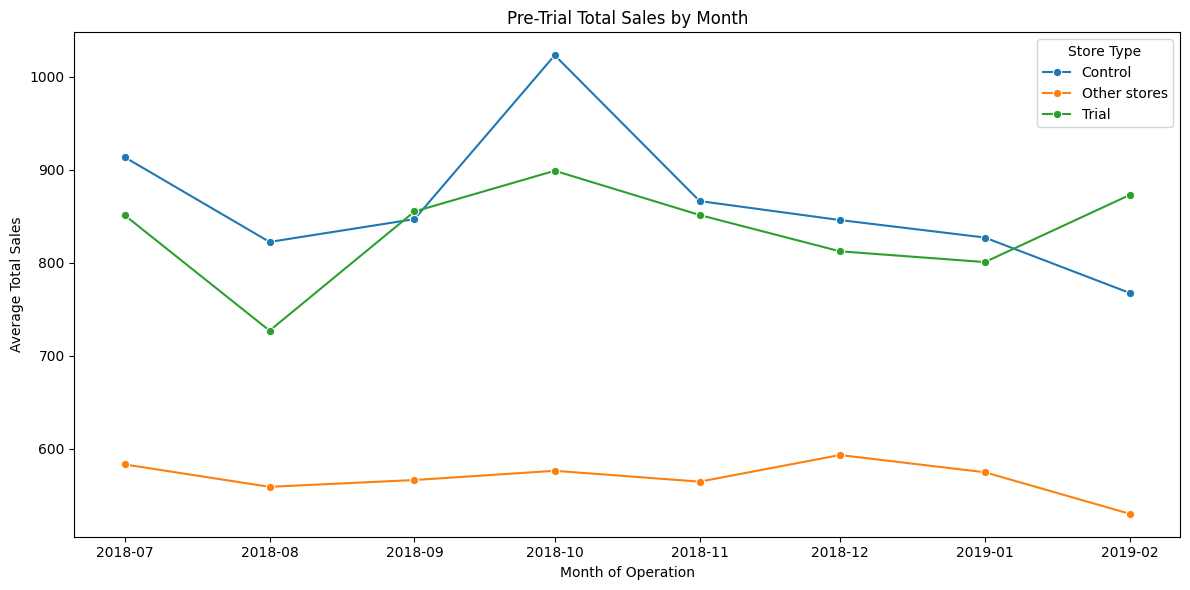

In [59]:
# --- Visual checks on trends based on the drivers ---

print("\n--- Visualizing Pre-Trial Sales Trends ---")
# Convert YEARMONTH to datetime object for plotting
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales['TransactionMonth'] = pd.to_datetime(measureOverTimeSales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for pre-trial period (up to Feb 2019, which is 201902)
pastSales = measureOverTimeSales[measureOverTimeSales['YEARMONTH'] < 201903].copy()

# Categorize stores for plotting
pastSales['Store_type'] = 'Other stores'
pastSales.loc[pastSales['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
if control_store is not None:
    pastSales.loc[pastSales['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Aggregate sales by YEARMONTH and Store_type
pastSales_agg = pastSales.groupby(['YEARMONTH', 'Store_type', 'TransactionMonth'])['totSales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=pastSales_agg, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')
plt.title("Pre-Trial Total Sales by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Average Total Sales")
plt.legend(title="Store Type")
plt.tight_layout()
plt.show()


--- Visualizing Pre-Trial Customer Trends ---


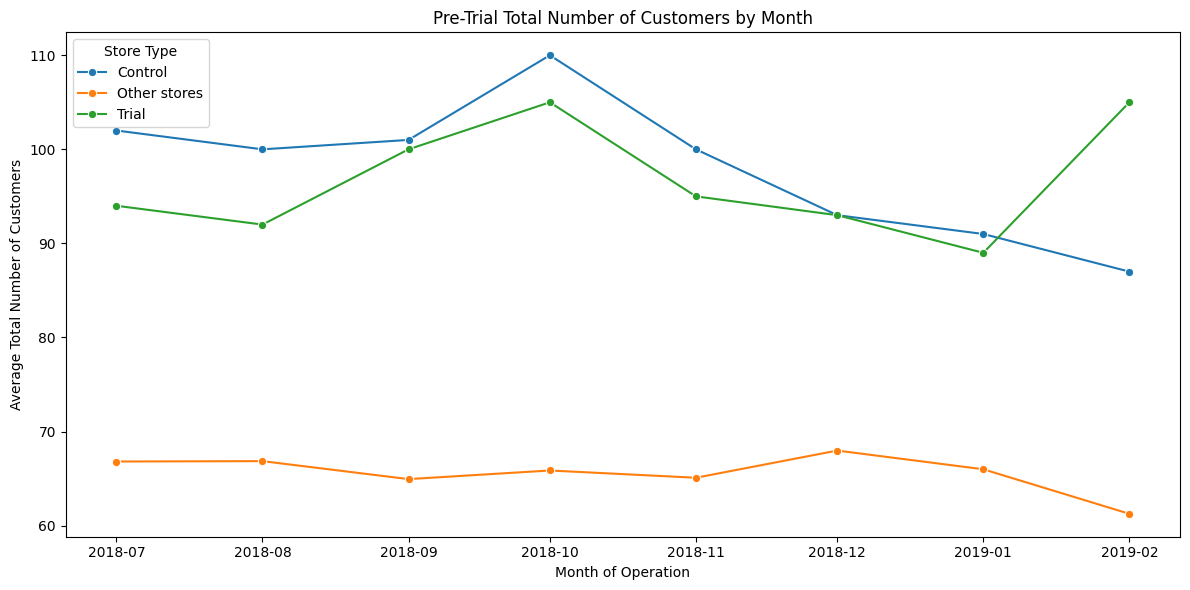

In [60]:
print("\n--- Visualizing Pre-Trial Customer Trends ---")
measureOverTimeCusts = measureOverTime.copy()
measureOverTimeCusts['TransactionMonth'] = pd.to_datetime(measureOverTimeCusts['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

pastCustomers = measureOverTimeCusts[measureOverTimeCusts['YEARMONTH'] < 201903].copy()

pastCustomers['Store_type'] = 'Other stores'
pastCustomers.loc[pastCustomers['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
if control_store is not None:
    pastCustomers.loc[pastCustomers['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

pastCustomers_agg = pastCustomers.groupby(['YEARMONTH', 'Store_type', 'TransactionMonth'])['nCustomers'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCustomers_agg, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')
plt.title("Pre-Trial Total Number of Customers by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Average Total Number of Customers")
plt.legend(title="Store Type")
plt.tight_layout()
plt.show()

## Assessment of trial

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales


--- Analyzing Uplift for Trial Store 86 using Control Store 114 ---
Scaling Factor for Control Sales: 0.94
Standard Deviation of Pre-Trial Percentage Difference: 0.0619

T-values for trial period:
TransactionMonth   tValue
      2019-03-01 1.509216
      2019-04-01 1.239571
      2019-05-01 4.177025
      2019-06-01 2.314065

95th percentile (t-critical value) with 7 degrees of freedom: 1.895

--- Visualizing Sales with Control Store Confidence Intervals ---


C:\Users\olade\AppData\Local\Temp\ipykernel_26688\1339539296.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  control_sales_for_bounds['controlSales'].fillna(control_sales_for_bounds['totSales'], inplace=True) # Use original totSales if scaled not available for a month


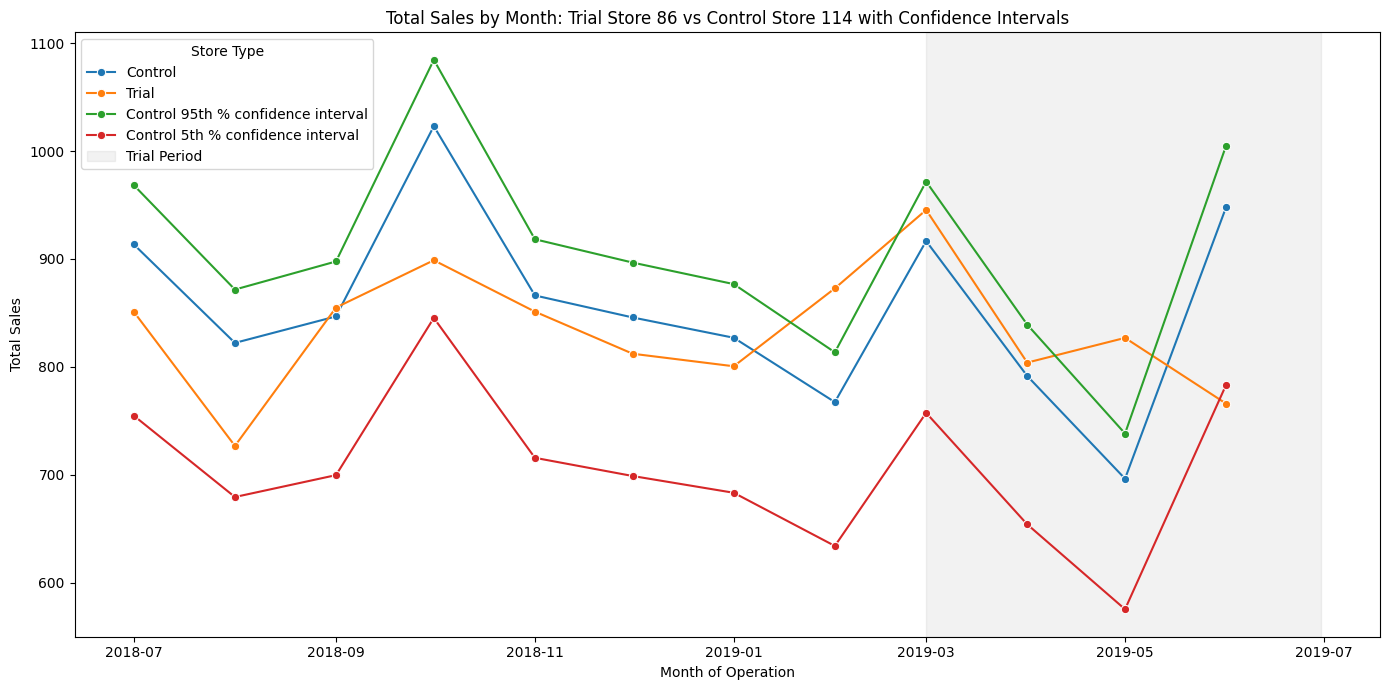

In [61]:
if control_store is not None:
    print(f"\n--- Analyzing Uplift for Trial Store {trial_store} using Control Store {int(control_store)} ---")

    # Scale pre-trial control sales to match pre-trial trial store sales using pre-trial period up to Feb 2019 (201902)
    
    # Sum sales for the pre-trial period (e.g., 201807 to 201902)
    trial_store_sum_sales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201903)]['totSales'].sum()
    control_store_sum_sales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201903)]['totSales'].sum()

    if control_store_sum_sales == 0:
        print("Warning: Control store pre-trial sales sum is zero, cannot calculate scaling factor.")
        scalingFactorForControlSales = 1.0 # Avoid division by zero
    else:
        scalingFactorForControlSales = trial_store_sum_sales / control_store_sum_sales

    print(f"Scaling Factor for Control Sales: {scalingFactorForControlSales:.2f}")

    # Apply the scaling factor
    # Ensure this uses 'measureOverTime' which includes trial period data
    scaledControlSales = measureOverTime[measureOverTime['STORE_NBR'] == control_store].copy()
    scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales

    # Calculate the percentage difference between scaled control sales and trial sales
    # Filter measureOverTime for the trial store
    trial_sales_data = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']].copy()
    
    percentageDiff = pd.merge(scaledControlSales[['YEARMONTH', 'controlSales']],
                              trial_sales_data,
                              on="YEARMONTH",
                              how='inner')
    percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

    # As our null hypothesis is that the trial period is the same as the pre-trial period,
    # let's take the standard deviation based on the scaled percentage difference in the pre-trial period
    
    # Filter for pre-trial period (up to Feb 2019, 201902)
    pre_trial_percentage_diff = percentageDiff[percentageDiff['YEARMONTH'] < 201903]['percentageDiff']
    
    stdDev = pre_trial_percentage_diff.std()
    print(f"Standard Deviation of Pre-Trial Percentage Difference: {stdDev:.4f}")

    # Note that there are 8 months in the pre-trial period (July 2018 - Feb 2019)
    # Hence 8 - 1 = 7 degrees of freedom
    degreesOfFreedom = len(pre_trial_percentage_diff) - 1 if len(pre_trial_percentage_diff) > 1 else 0
    if degreesOfFreedom <= 0:
        print("Warning: Not enough data for t-test. Degrees of freedom is 0 or less.")
    else:
        # Calculate t-value for trial period months (March 2019 to June 2019)
        trial_period_diff = percentageDiff[(percentageDiff['YEARMONTH'] >= 201903) & (percentageDiff['YEARMONTH'] <= 201906)].copy()
        
        # Calculate t-value
        # If stdDev is 0, t-value would be Inf or NaN.
        if stdDev == 0:
            trial_period_diff['tValue'] = np.nan
        else:
            trial_period_diff['tValue'] = (trial_period_diff['percentageDiff'] - 0) / stdDev

        trial_period_diff['TransactionMonth'] = pd.to_datetime(trial_period_diff['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        print("\nT-values for trial period:")
        print(trial_period_diff[['TransactionMonth', 'tValue']].to_string(index=False))

        # Find the 95th percentile of the t distribution with the appropriate degrees of freedom to compare against
        t_critical_value = t_dist.ppf(0.95, df=degreesOfFreedom)
        print(f"\n95th percentile (t-critical value) with {degreesOfFreedom} degrees of freedom: {t_critical_value:.3f}")

        # --- Visualizing Sales with Confidence Intervals ---
        print("\n--- Visualizing Sales with Control Store Confidence Intervals ---")
        
        # Prepare data for plotting (Trial and Control store total sales)
        # Filter for Trial and Control stores from the full 'measureOverTime'
        pastSales_viz = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])].copy()
        pastSales_viz['Store_type'] = np.where(pastSales_viz['STORE_NBR'] == trial_store, "Trial", "Control")
        pastSales_viz['TransactionMonth'] = pd.to_datetime(pastSales_viz['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        
        # We need the mean totSales by YEARMONTH and Store_type for consistent plotting
        pastSales_viz_agg = pastSales_viz.groupby(['YEARMONTH', 'Store_type', 'TransactionMonth'])['totSales'].mean().reset_index()

        # Calculate Control store 95th percentile (upper bound)
        # Apply scaling factor to control sales before calculating bounds for accurate comparison
        control_sales_scaled_for_viz = scaledControlSales[['YEARMONTH', 'controlSales']].copy()
        control_sales_scaled_for_viz['TransactionMonth'] = pd.to_datetime(control_sales_scaled_for_viz['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        
        # Join the scaled control sales with the full historical data to ensure all months are present
        control_sales_for_bounds = pd.merge(pastSales_viz_agg[pastSales_viz_agg['Store_type'] == 'Control'],
                                            control_sales_scaled_for_viz,
                                            on=['YEARMONTH', 'TransactionMonth'],
                                            how='left')
        control_sales_for_bounds['controlSales'].fillna(control_sales_for_bounds['totSales'], inplace=True) # Use original totSales if scaled not available for a month
        
        pastSales_Controls95 = control_sales_for_bounds.copy()
        pastSales_Controls95['totSales'] = pastSales_Controls95['controlSales'] * (1 + stdDev * 2) # Use scaled control sales for bounds
        pastSales_Controls95['Store_type'] = "Control 95th % confidence interval"

        # Calculate Control store 5th percentile (lower bound)
        pastSales_Controls5 = control_sales_for_bounds.copy()
        pastSales_Controls5['totSales'] = pastSales_Controls5['controlSales'] * (1 - stdDev * 2) # Use scaled control sales for bounds
        pastSales_Controls5['Store_type'] = "Control 5th % confidence interval"

        # Combine all data for plotting
        trialAssessment = pd.concat([
            pastSales_viz_agg,
            pastSales_Controls95[['YEARMONTH', 'Store_type', 'TransactionMonth', 'totSales']],
            pastSales_Controls5[['YEARMONTH', 'Store_type', 'TransactionMonth', 'totSales']]
        ], ignore_index=True)

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')

        # Add shaded rectangle for the trial period (March 2019 to June 2019)
        # Find min/max transaction dates for the trial period
        trial_start_date = pd.to_datetime('2019-03-01')
        trial_end_date = pd.to_datetime('2019-06-01') # This assumes data points are start of month
        # Adjust xmax for the rectangle to cover the full month if plotting by start of month
        trial_end_date_for_rect = pd.to_datetime('2019-06-30') # Extend to end of last trial month

        plt.axvspan(trial_start_date, trial_end_date_for_rect, color='gray', alpha=0.1, label='Trial Period')
        
        plt.title(f"Total Sales by Month: Trial Store {trial_store} vs Control Store {int(control_store)} with Confidence Intervals")
        plt.xlabel("Month of Operation")
        plt.ylabel("Total Sales")
        plt.legend(title="Store Type")
        plt.tight_layout()
        plt.show()
else:
    print("Cannot perform uplift analysis as no control store was selected.")


--- Analyzing Uplift for Trial Store 86 using Control Store 114 (Sales) ---
Scaling Factor for Control Sales: 0.94
Standard Deviation of Pre-Trial Sales Percentage Difference: 0.0619

T-values for sales in trial period:
TransactionMonth   tValue
      2019-03-01 1.509216
      2019-04-01 1.239571
      2019-05-01 4.177025
      2019-06-01 2.314065

95th percentile (t-critical value) with 7 degrees of freedom: 1.895

--- Visualizing Sales with Control Store Confidence Intervals ---


C:\Users\olade\AppData\Local\Temp\ipykernel_26688\4261626266.py:75: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  control_sales_for_bounds['controlSales'].fillna(control_sales_for_bounds['totSales'], inplace=True)


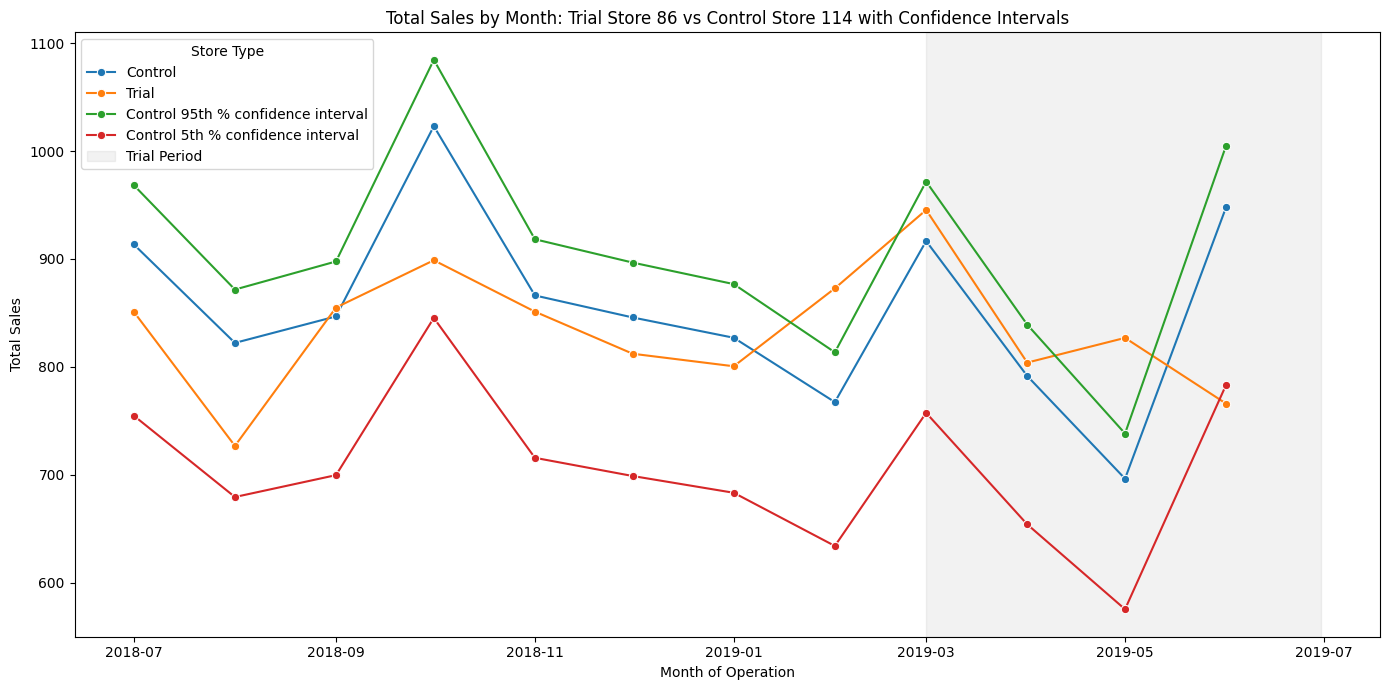


--- Analyzing Uplift for Trial Store 86 using Control Store 114 (Customers) ---
Scaling Factor for Control Customers: 0.96
Standard Deviation of Pre-Trial Customers Percentage Difference: 0.0835

T-values for customers in trial period:
TransactionMonth   tValue
      2019-03-01 0.636936
      2019-04-01 1.185030
      2019-05-01 2.579019
      2019-06-01 0.479934

95th percentile (t-critical value) with 7 degrees of freedom: 1.895

--- Visualizing Customers with Control Store Confidence Intervals ---


C:\Users\olade\AppData\Local\Temp\ipykernel_26688\4261626266.py:179: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  control_customers_for_bounds['controlCustomers'].fillna(control_customers_for_bounds['nCustomers'], inplace=True)


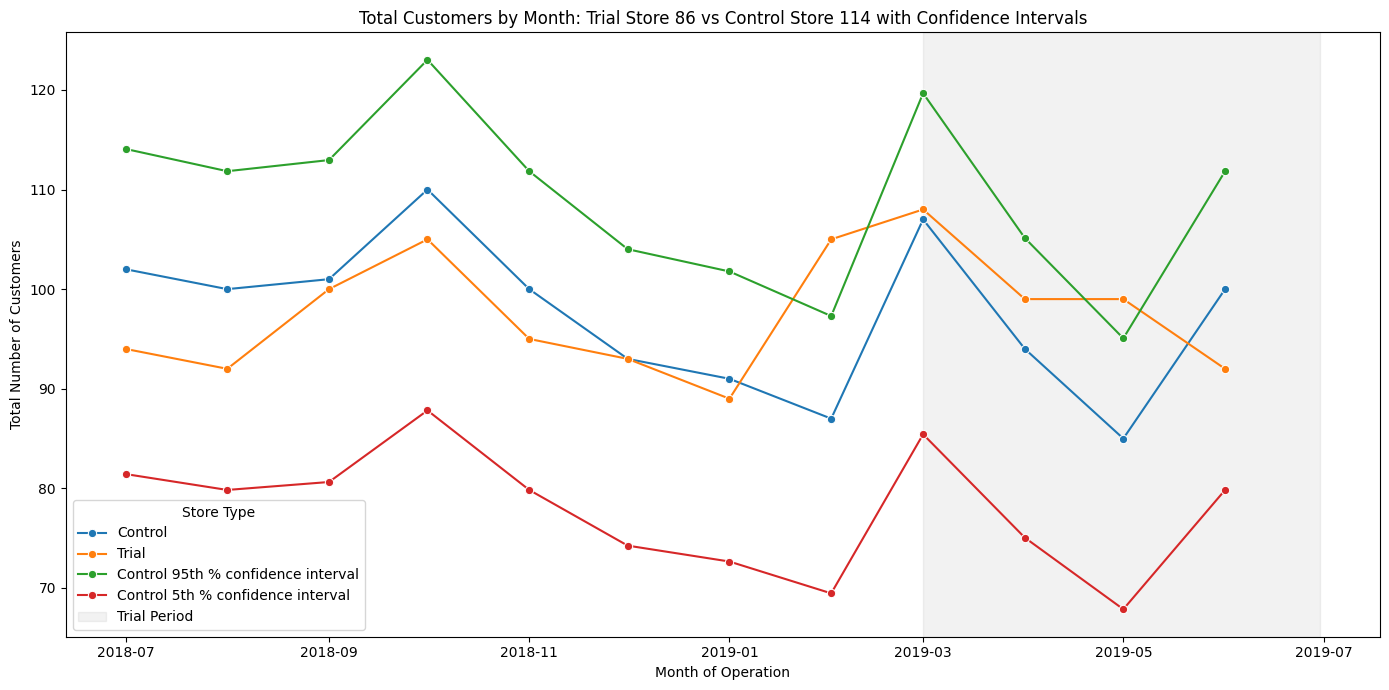

In [62]:
# --- Trial Period Uplift Analysis for Sales ---

if control_store is not None:
    print(f"\n--- Analyzing Uplift for Trial Store {trial_store} using Control Store {int(control_store)} (Sales) ---")

    # Scale pre-trial control sales to match pre-trial trial store sales
    trial_store_sum_sales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201903)]['totSales'].sum()
    control_store_sum_sales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201903)]['totSales'].sum()

    if control_store_sum_sales == 0:
        print("Warning: Control store pre-trial sales sum is zero, cannot calculate scaling factor.")
        scalingFactorForControlSales = 1.0 # Avoid division by zero
    else:
        scalingFactorForControlSales = trial_store_sum_sales / control_store_sum_sales

    print(f"Scaling Factor for Control Sales: {scalingFactorForControlSales:.2f}")

    # Apply the scaling factor
    scaledControlSales = measureOverTime[measureOverTime['STORE_NBR'] == control_store].copy()
    scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales

    # Calculate the percentage difference between scaled control sales and trial sales
    trial_sales_data = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']].copy()

    percentageDiffSales = pd.merge(scaledControlSales[['YEARMONTH', 'controlSales']],
                              trial_sales_data,
                              on="YEARMONTH",
                              how='inner')
    percentageDiffSales['percentageDiff'] = abs(percentageDiffSales['controlSales'] - percentageDiffSales['totSales']) / percentageDiffSales['controlSales']

    # As our null hypothesis is that the trial period is the same as the pre-trial period,
    # let's take the standard deviation based on the scaled percentage difference in the pre-trial period
    pre_trial_percentage_diff_sales = percentageDiffSales[percentageDiffSales['YEARMONTH'] < 201903]['percentageDiff']
    
    stdDevSales = pre_trial_percentage_diff_sales.std()
    print(f"Standard Deviation of Pre-Trial Sales Percentage Difference: {stdDevSales:.4f}")

    degreesOfFreedom = len(pre_trial_percentage_diff_sales) - 1 if len(pre_trial_percentage_diff_sales) > 1 else 0
    if degreesOfFreedom <= 0:
        print("Warning: Not enough data for t-test (Sales). Degrees of freedom is 0 or less.")
    else:
        # Calculate t-value for trial period months (March 2019 to June 2019)
        trial_period_diff_sales = percentageDiffSales[(percentageDiffSales['YEARMONTH'] >= 201903) & (percentageDiffSales['YEARMONTH'] <= 201906)].copy()
        
        if stdDevSales == 0:
            trial_period_diff_sales['tValue'] = np.nan
            print("Warning: Standard deviation for sales is zero, t-values will be NaN.")
        else:
            trial_period_diff_sales['tValue'] = (trial_period_diff_sales['percentageDiff'] - 0) / stdDevSales

        trial_period_diff_sales['TransactionMonth'] = pd.to_datetime(trial_period_diff_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        print("\nT-values for sales in trial period:")
        print(trial_period_diff_sales[['TransactionMonth', 'tValue']].to_string(index=False))

        t_critical_value = t_dist.ppf(0.95, df=degreesOfFreedom)
        print(f"\n95th percentile (t-critical value) with {degreesOfFreedom} degrees of freedom: {t_critical_value:.3f}")

        # --- Visualizing Sales with Confidence Intervals ---
        print("\n--- Visualizing Sales with Control Store Confidence Intervals ---")
        
        # Prepare data for plotting (Trial and Control store total sales)
        pastSales_viz = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])].copy()
        pastSales_viz['Store_type'] = np.where(pastSales_viz['STORE_NBR'] == trial_store, "Trial", "Control")
        pastSales_viz['TransactionMonth'] = pd.to_datetime(pastSales_viz['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        
        pastSales_viz_agg = pastSales_viz.groupby(['YEARMONTH', 'Store_type', 'TransactionMonth'])['totSales'].mean().reset_index()

        control_sales_scaled_for_viz = scaledControlSales[['YEARMONTH', 'controlSales']].copy()
        control_sales_scaled_for_viz['TransactionMonth'] = pd.to_datetime(control_sales_scaled_for_viz['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        
        control_sales_for_bounds = pd.merge(pastSales_viz_agg[pastSales_viz_agg['Store_type'] == 'Control'],
                                            control_sales_scaled_for_viz,
                                            on=['YEARMONTH', 'TransactionMonth'],
                                            how='left')
        control_sales_for_bounds['controlSales'].fillna(control_sales_for_bounds['totSales'], inplace=True)
        
        pastSales_Controls95 = control_sales_for_bounds.copy()
        pastSales_Controls95['totSales'] = pastSales_Controls95['controlSales'] * (1 + stdDevSales * 2)
        pastSales_Controls95['Store_type'] = "Control 95th % confidence interval"

        pastSales_Controls5 = control_sales_for_bounds.copy()
        pastSales_Controls5['totSales'] = pastSales_Controls5['controlSales'] * (1 - stdDevSales * 2)
        pastSales_Controls5['Store_type'] = "Control 5th % confidence interval"

        trialAssessmentSales = pd.concat([
            pastSales_viz_agg,
            pastSales_Controls95[['YEARMONTH', 'Store_type', 'TransactionMonth', 'totSales']],
            pastSales_Controls5[['YEARMONTH', 'Store_type', 'TransactionMonth', 'totSales']]
        ], ignore_index=True)

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=trialAssessmentSales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')

        trial_start_date = pd.to_datetime('2019-03-01')
        trial_end_date = pd.to_datetime('2019-06-01')
        trial_end_date_for_rect = pd.to_datetime('2019-06-30')

        plt.axvspan(trial_start_date, trial_end_date_for_rect, color='gray', alpha=0.1, label='Trial Period')
        
        plt.title(f"Total Sales by Month: Trial Store {trial_store} vs Control Store {int(control_store)} with Confidence Intervals")
        plt.xlabel("Month of Operation")
        plt.ylabel("Total Sales")
        plt.legend(title="Store Type")
        plt.tight_layout()
        plt.show()

    # --- Trial Period Uplift Analysis for Customers ---

    print(f"\n--- Analyzing Uplift for Trial Store {trial_store} using Control Store {int(control_store)} (Customers) ---")

    # Scale pre-trial control customers to match pre-trial trial store customers
    trial_store_sum_customers = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201903)]['nCustomers'].sum()
    control_store_sum_customers = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201903)]['nCustomers'].sum()

    if control_store_sum_customers == 0:
        print("Warning: Control store pre-trial customers sum is zero, cannot calculate scaling factor.")
        scalingFactorForControlCustomers = 1.0 # Avoid division by zero
    else:
        scalingFactorForControlCustomers = trial_store_sum_customers / control_store_sum_customers

    print(f"Scaling Factor for Control Customers: {scalingFactorForControlCustomers:.2f}")

    # Apply the scaling factor
    scaledControlCustomers = measureOverTime[measureOverTime['STORE_NBR'] == control_store].copy()
    scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorForControlCustomers

    # Calculate the percentage difference between scaled control customers and trial customers
    trial_customers_data = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']].copy()

    percentageDiffCustomers = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                                  trial_customers_data,
                                  on="YEARMONTH",
                                  how='inner')
    percentageDiffCustomers['percentageDiff'] = abs(percentageDiffCustomers['controlCustomers'] - percentageDiffCustomers['nCustomers']) / percentageDiffCustomers['controlCustomers']

    # Take the standard deviation based on the scaled percentage difference in the pre-trial period
    pre_trial_percentage_diff_customers = percentageDiffCustomers[percentageDiffCustomers['YEARMONTH'] < 201903]['percentageDiff']
    
    stdDevCustomers = pre_trial_percentage_diff_customers.std()
    print(f"Standard Deviation of Pre-Trial Customers Percentage Difference: {stdDevCustomers:.4f}")

    degreesOfFreedomCustomers = len(pre_trial_percentage_diff_customers) - 1 if len(pre_trial_percentage_diff_customers) > 1 else 0
    if degreesOfFreedomCustomers <= 0:
        print("Warning: Not enough data for t-test (Customers). Degrees of freedom is 0 or less.")
    else:
        # Calculate t-value for trial period months (March 2019 to June 2019)
        trial_period_diff_customers = percentageDiffCustomers[(percentageDiffCustomers['YEARMONTH'] >= 201903) & (percentageDiffCustomers['YEARMONTH'] <= 201906)].copy()
        
        if stdDevCustomers == 0:
            trial_period_diff_customers['tValue'] = np.nan
            print("Warning: Standard deviation for customers is zero, t-values will be NaN.")
        else:
            trial_period_diff_customers['tValue'] = (trial_period_diff_customers['percentageDiff'] - 0) / stdDevCustomers

        trial_period_diff_customers['TransactionMonth'] = pd.to_datetime(trial_period_diff_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        print("\nT-values for customers in trial period:")
        print(trial_period_diff_customers[['TransactionMonth', 'tValue']].to_string(index=False))

        t_critical_value_customers = t_dist.ppf(0.95, df=degreesOfFreedomCustomers)
        print(f"\n95th percentile (t-critical value) with {degreesOfFreedomCustomers} degrees of freedom: {t_critical_value_customers:.3f}")

        # --- Visualizing Customers with Confidence Intervals ---
        print("\n--- Visualizing Customers with Control Store Confidence Intervals ---")
        
        # Prepare data for plotting (Trial and Control store total customers)
        pastCustomers_viz = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])].copy()
        pastCustomers_viz['Store_type'] = np.where(pastCustomers_viz['STORE_NBR'] == trial_store, "Trial", "Control")
        pastCustomers_viz['TransactionMonth'] = pd.to_datetime(pastCustomers_viz['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        
        pastCustomers_viz_agg = pastCustomers_viz.groupby(['YEARMONTH', 'Store_type', 'TransactionMonth'])['nCustomers'].mean().reset_index()

        control_customers_scaled_for_viz = scaledControlCustomers[['YEARMONTH', 'controlCustomers']].copy()
        control_customers_scaled_for_viz['TransactionMonth'] = pd.to_datetime(control_customers_scaled_for_viz['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
        
        control_customers_for_bounds = pd.merge(pastCustomers_viz_agg[pastCustomers_viz_agg['Store_type'] == 'Control'],
                                            control_customers_scaled_for_viz,
                                            on=['YEARMONTH', 'TransactionMonth'],
                                            how='left')
        control_customers_for_bounds['controlCustomers'].fillna(control_customers_for_bounds['nCustomers'], inplace=True)
        
        pastCustomers_Controls95 = control_customers_for_bounds.copy()
        pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['controlCustomers'] * (1 + stdDevCustomers * 2)
        pastCustomers_Controls95['Store_type'] = "Control 95th % confidence interval"

        pastCustomers_Controls5 = control_customers_for_bounds.copy()
        pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['controlCustomers'] * (1 - stdDevCustomers * 2)
        pastCustomers_Controls5['Store_type'] = "Control 5th % confidence interval"

        trialAssessmentCustomers = pd.concat([
            pastCustomers_viz_agg,
            pastCustomers_Controls95[['YEARMONTH', 'Store_type', 'TransactionMonth', 'nCustomers']],
            pastCustomers_Controls5[['YEARMONTH', 'Store_type', 'TransactionMonth', 'nCustomers']]
        ], ignore_index=True)

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=trialAssessmentCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')

        plt.axvspan(trial_start_date, trial_end_date_for_rect, color='gray', alpha=0.1, label='Trial Period')
        
        plt.title(f"Total Customers by Month: Trial Store {trial_store} vs Control Store {int(control_store)} with Confidence Intervals")
        plt.xlabel("Month of Operation")
        plt.ylabel("Total Number of Customers")
        plt.legend(title="Store Type")
        plt.tight_layout()
        plt.show()
else:
    print("Cannot perform uplift analysis as no control store was selected.")
